In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU


In [55]:

ticker = 'BTC-USD'
df = yf.download(ticker, period="max", interval="1d")
df.to_csv("bitcoin_diario.csv")

df

print(df.info())


C:\Users\jeron\AppData\Local\Temp\ipykernel_41004\1558679595.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", interval="1d")
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4038 entries, 2014-09-17 to 2025-10-07
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   4038 non-null   float64
 1   (High, BTC-USD)    4038 non-null   float64
 2   (Low, BTC-USD)     4038 non-null   float64
 3   (Open, BTC-USD)    4038 non-null   float64
 4   (Volume, BTC-USD)  4038 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 189.3 KB
None


In [56]:
#Preparar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(3938, 100, 1)

In [57]:
#Construir el modelo

print('Comenzando el entrenamiento...')

modelo = Sequential()

#Capa 1
modelo.add(GRU(units=50, return_sequences = True, input_shape = (x_train.shape[1],1)))
modelo.add(Dropout(0.2))

#Capa 2
modelo.add(GRU(units=50, return_sequences = True))
modelo.add(Dropout(0.2))

#Capa 3
modelo.add(GRU(units=50))
modelo.add(Dropout(0.1))

#Capa 4
modelo.add(Dense(units = 1))



modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.fit(x_train, y_train, epochs=25, batch_size=32)
print("Modelo entrenado exitosamente")

Comenzando el entrenamiento...
Epoch 1/25


c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0049
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0011
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0011
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 8.7775e-04
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 9.7452e-04
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 8.9202e-04
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 7.2753e-04
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 8.4652e-04
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 7.0042e-04
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 6.6280e-04
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 6.2437e-04
Epoch 12/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 6.2385e-04
Epoch 13/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 5.9167e-04
Epoch 14/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 5.9615e-04
Epoch 15/

In [58]:
#Datos Test
ticker = 'BTC-USD'
df_test = yf.download(ticker, period="max", interval="1d")
df_test.to_csv("bitcoin_diario.csv")


actual_prices = df_test["Close"].values

total_dataset = pd.concat((df['Close'],df_test['Close']),axis=0)
modelo_inputs = total_dataset[len(total_dataset)-len(df_test)-prediction_days:].values
modelo_inputs = scaler.transform(modelo_inputs.reshape(-1,1))


C:\Users\jeron\AppData\Local\Temp\ipykernel_41004\3563527878.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(ticker, period="max", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [59]:
#Test

x_test = []

for x in range(prediction_days,len(modelo_inputs)):
  x_test.append(modelo_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = modelo.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


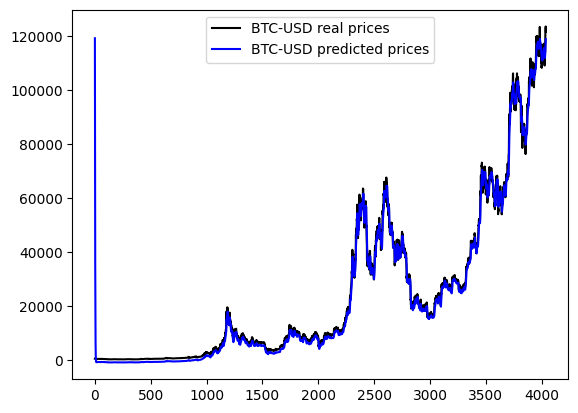

In [60]:
plt.plot(actual_prices,color="black",label=f"{ticker} real prices")
plt.plot(predicted_prices,color="blue",label=f"{ticker} predicted prices")
plt.legend()
plt.show()

In [61]:
rentability = 1
for i in range(1,len(actual_prices)):
  if predicted_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

print((rentability-1)*100,"%")

[46.37071309] %


In [62]:
directional_accuracy = np.mean(
    (np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
     np.sign(actual_prices[1:] - actual_prices[:-1]))
)
print("Precisión direccional:", directional_accuracy*100, "%")

Precisión direccional: 49.44265543720584 %


In [63]:
daily_return = (rentability ** (1/len(actual_prices))) - 1
print(daily_return * 100, "% por día")

[0.00943512] % por día


In [ ]:
#Prediccion siguiente dia

window_size = x_train.shape[1]
ultimos_close = df['Close'].values[-window_size:].reshape(-1, 1)
ultima_ventana = scaler.transform(ultimos_close)
x_input = ultima_ventana.reshape(1, window_size, 1)
pred_esc = modelo.predict(x_input)
pred_real = scaler.inverse_transform(pred_esc)

print(pred_real)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[119150.99]]


In [65]:
# Predicicon proximos 10 dias


dias_a_predecir = 10
window_size = x_train.shape[1]  


ultimos_close = df['Close'].values[-window_size:].reshape(-1, 1)


ultima_ventana = scaler.transform(ultimos_close)  

predicciones_futuras = []

#Predicciones siguientes 10 dias
for i in range(dias_a_predecir):
    x_input = ultima_ventana.reshape(1, window_size, 1)   
    pred_esc = modelo.predict(x_input, verbose=0)         
    predicciones_futuras.append(pred_esc[0, 0])

    
    ultima_ventana = np.append(ultima_ventana, pred_esc)[1:].reshape(-1, 1)


predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_usd = scaler.inverse_transform(predicciones_futuras)

print(predicciones_futuras_usd)



[[119150.99 ]
 [118826.66 ]
 [118653.445]
 [118566.21 ]
 [118510.05 ]
 [118469.63 ]
 [118439.91 ]
 [118417.74 ]
 [118401.195]
 [118388.945]]
